# Cyaberbullying Detection on Social Media Platforms using GPT-2.0 

In [2]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from transformers import GPT2Tokenizer, TFGPT2Model
from sklearn.model_selection import train_test_split
import time
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Text cleaning
import re
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords


# Data preprocessing
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize

# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

In [10]:
# Load the dataset
df = pd.read_csv('../datasets/cb_multi_labeled_unbalanced.csv', encoding='ISO-8859-1')

In [11]:
df.columns

Index(['text', 'label'], dtype='object')

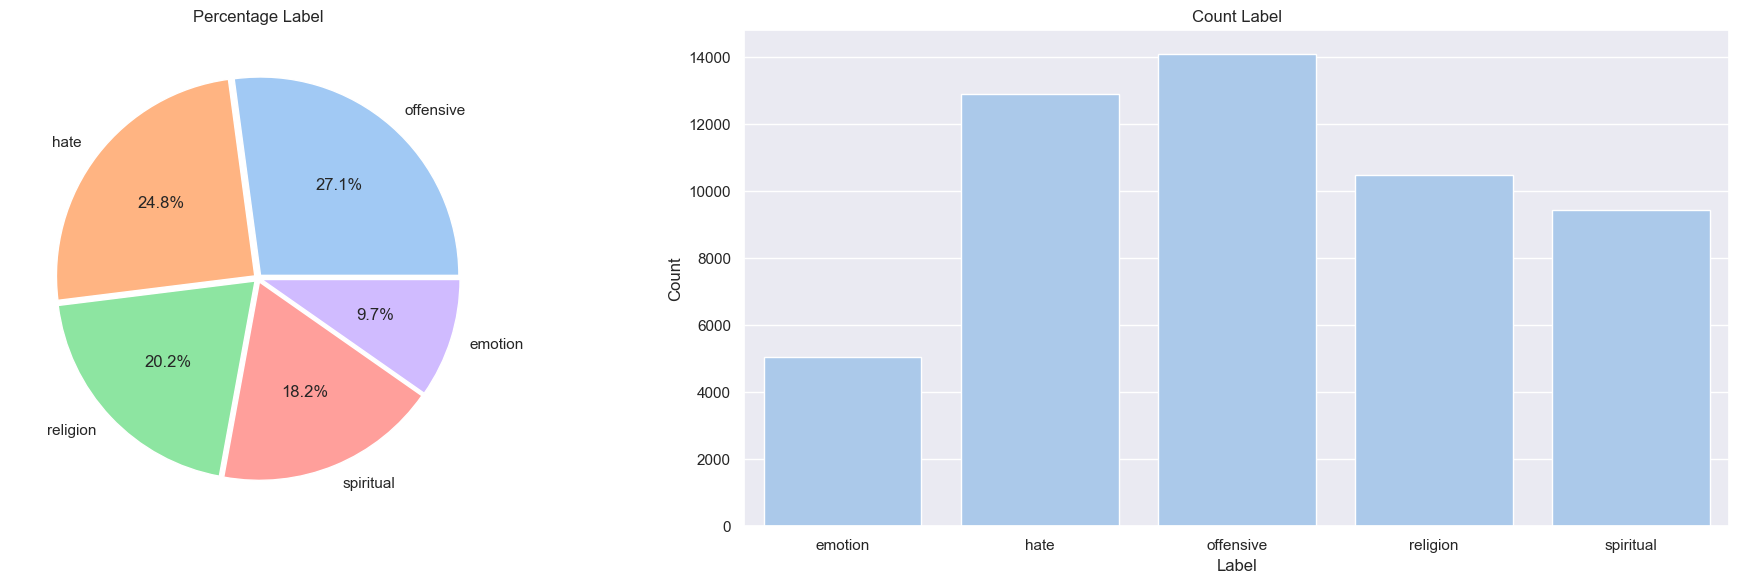

In [13]:
# Filter out the 'other_cyberbullying' category
#df = df[df['cyberbullying_type'] != 'other_cyberbullying']

# Ensure 'cyberbullying_type' is a categorical variable
df['label'] = df['label'].astype('category')

# Get value counts for the pie chart
label_count = df['label'].value_counts()

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

# Set theme and color palette
sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')
explode = [0.02]*len(label_count)

# Plot pie chart
axes[0].pie(label_count.values, labels=label_count.index, autopct='%1.1f%%', colors=color, explode=explode)
axes[0].set_title('Percentage Label')

# Plot countplot
sns.countplot(x='label', data=df, ax=axes[1])
axes[1].set_title('Count Label')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

# Adjust layout and display plot
plt.tight_layout()
plt.show()

In [5]:
# Safely split the 'text,label' column into 'text' and 'label'
#split_columns = df['text,label'].str.split(',', n=1, expand=True)
#if split_columns.shape[1] < 2:
    #print("Warning: Some rows are missing a comma. Fixing data...")

In [6]:
# Assign split columns to new 'text' and 'label' columns
#df[['text', 'label']] = split_columns

In [7]:
# Drop rows where splitting failed (optional, depending on your needs)
#df.dropna(subset=['text', 'label'], inplace=True)

In [8]:
# Drop the original combined column
#df.drop(columns=['text,label'], inplace=True)

In [9]:
# Clean emojis from text
def strip_emoji(text):
    # Ensure the input is a string
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    
    emoji_pattern = re.compile(
        "[\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F700-\U0001F77F"  # alchemical symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed characters
        "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)

# Remove punctuations, stopwords, links, mentions, and new line characters
def strip_all_entities(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
        
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    if not isinstance(tweet, str):
        tweet = str(tweet)  # Convert non-strings to string (e.g., float, NaN)
    
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()
    
    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()
    
    return new_tweet

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    return ' '.join(text.split())

# Remove URL shorteners
def remove_url_shorteners(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    if not isinstance(tweet, str):
        tweet = str(tweet)  # Convert non-strings to string (e.g., float, NaN)
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    if not isinstance(tweet, str):
        tweet = str(tweet)  # Convert non-strings to string (e.g., float, NaN)
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    if not isinstance(tweet, str):
        tweet = str(tweet)  # Ensure tweet is a string
    
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

In [10]:
df['text_clean'] = [clean_tweet(tweet) for tweet in df['text']]

In [11]:
df.head()

,text,label,text_clean
0,@user nice new signage. Are you not concerned ...,hate,nice new signage concerned beatlemania style h...
1,A woman who you fucked multiple times saying y...,hate,woman fucked multiple time saying yo dick smal...
2,@user @user real talk do you have eyes or were...,hate,real talk eye gouged rapefugee
3,your girlfriend lookin at me like a groupie in...,hate,girlfriend lookin like groupie bitch
4,Hysterical woman like @user,hate,


In [12]:
print(f'There are around {int(df["text_clean"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 4592 duplicated tweets, we will remove them.


In [13]:
df.drop_duplicates("text_clean", inplace=True)

In [14]:
df.label.value_counts()

label
hate         12117
offensive    11932
religion     10152
spiritual     8553
emotion       4640
Name: count, dtype: int64

In [15]:
#df = df[df["cyberbullying_type"]!="other_cyberbullying"]

In [18]:
# Define features and labels
X = df['text_clean']  # Text data
y = df['label']  # Labels

In [19]:
# Map sentiment labels
def map_sentiment(value):
    if value == 'emotion':
        return 0
    elif value == 'spiritual':
        return 1
    elif value == 'religion':
        return 2
    elif value == 'offensive':
        return 3
    elif value == 'hate':
        return 4
    else:
        return None  # Handle unexpected or missing values    

In [20]:
# Apply the mapping function to the labels
y = y.apply(map_sentiment)

In [21]:
# Drop rows with invalid labels
valid_mask = y.notnull()

In [22]:
# Filter valid rows in X and y
X = X[valid_mask]
y = y[valid_mask]

In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data has been split successfully!")

Data has been split successfully!


In [24]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'label']);

In [25]:
X_train = train_os['text_clean'].values
y_train = train_os['label'].values

In [26]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 9716],
       [   1, 9716],
       [   2, 9716],
       [   3, 9716],
       [   4, 9716]], dtype=int64)

In [27]:
# Compute the maximum sequence length
X_train = pd.Series(X_train)
MAX_LENGTH = math.ceil((X_train.apply(lambda x: len(str(x).split())).mean())) + 2
print("Max sequence length:", MAX_LENGTH)

Max sequence length: 16


In [28]:
# Define special tokens
PAD_TOKEN = "<|pad|>"
EOS_TOKEN = "<|endoftext|>"

# Initialize the pre-trained tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2",
    pad_token=PAD_TOKEN,
    eos_token=EOS_TOKEN,
    max_length=MAX_LENGTH,
    is_split_into_words=True)

In [29]:
# Add EOS token to each training and test text
X_train = [str(ex) + EOS_TOKEN for ex in X_train]
X_test = [str(ex) + EOS_TOKEN for ex in X_test]

In [30]:
# Tokenize the text
X_train_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)['input_ids'] for x in X_train]
X_test_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)['input_ids'] for x in X_test]

C:\Users\USTB\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [31]:
# Convert to tensor format
X_train_in = tf.squeeze(tf.convert_to_tensor(X_train_), axis=1)
X_test_in = tf.squeeze(tf.convert_to_tensor(X_test_), axis=1)

In [32]:
# Create attention masks for padding
X_train_mask_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)["attention_mask"] for x in X_train]
X_test_mask_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)["attention_mask"] for x in X_test]

In [33]:
# Convert to tensor format
X_train_mask = tf.squeeze(tf.convert_to_tensor(X_train_mask_), axis=1)
X_test_mask = tf.squeeze(tf.convert_to_tensor(X_test_mask_), axis=1)

In [34]:
# Load the GPT-2 model and freeze layers for fine-tuning
model = TFGPT2Model.from_pretrained("gpt2", use_cache=False,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id)
model.resize_token_embeddings(len(tokenizer))

for layer in model.layers:
    layer.trainable = False

All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [35]:
model.summary()

Model: "tfgpt2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLay  multiple                  124440576 
 er)                                                             
                                                                 
Total params: 124440576 (474.70 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 124440576 (474.70 MB)
_________________________________________________________________


In [36]:
# Define the input and mask layers for the model
input = tf.keras.layers.Input(shape=(None,), dtype='int32')
mask = tf.keras.layers.Input(shape=(None,), dtype='int32')

In [37]:
# Get GPT-2 output and process it
x = model(input, attention_mask=mask)
x = tf.reduce_mean(x.last_hidden_state, axis=1)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(5, activation='softmax')(x)

In [38]:
# Build the final model
clf = tf.keras.Model([input, mask], output)

In [39]:
clf.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 tfgpt2_model (TFGPT2Model)  TFBaseModelOutputWithPastA   1244405   ['input_1[0][0]',             
                             ndCrossAttentions(last_hid   76         'input_2[0][0]']             
                             den_state=(None, None, 768                                           
                             ),                                                               

In [40]:
# Set the learning rate and optimizer
base_learning_rate = 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)

In [41]:
# Use SparseCategoricalCrossentropy loss
loss = tf.keras.losses.SparseCategoricalCrossentropy()

clf.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [42]:
# Early stopping callback
callbacks = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy", verbose=1, patience=3, restore_best_weights=True)

In [43]:
# Convert labels to tensors
y_train_in = tf.constant(y_train, dtype=tf.int32)
y_test_in = tf.constant(y_test, dtype=tf.int32)

In [44]:
# Verify that labels are valid
print("Unique labels in y_train_in:", tf.unique(y_train_in)[0].numpy())
print("Unique labels in y_test_in:", tf.unique(y_test_in)[0].numpy())

Unique labels in y_train_in: [3 2 4 1 0]
Unique labels in y_test_in: [4 2 1 3 0]


In [45]:
# Train the model
history = clf.fit(
    [X_train_in, X_train_mask],
    y_train_in,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks
)

Epoch 1/10


1215/1215 [==============================] - 392s 315ms/step - loss: 1.4689 - accuracy: 0.4846 - val_loss: 1.3627 - val_accuracy: 0.3339
Epoch 2/10
1215/1215 [==============================] - 388s 319ms/step - loss: 1.0006 - accuracy: 0.5930 - val_loss: 1.0753 - val_accuracy: 0.4350
Epoch 3/10
1215/1215 [==============================] - 394s 324ms/step - loss: 0.9312 - accuracy: 0.6140 - val_loss: 1.0510 - val_accuracy: 0.4727
Epoch 4/10
1215/1215 [==============================] - 387s 318ms/step - loss: 0.8907 - accuracy: 0.6316 - val_loss: 1.0319 - val_accuracy: 0.5355
Epoch 5/10
1215/1215 [==============================] - 390s 321ms/step - loss: 0.8800 - accuracy: 0.6363 - val_loss: 1.0152 - val_accuracy: 0.5052
Epoch 6/10
1215/1215 [==============================] - 389s 320ms/step - loss: 0.8645 - accuracy: 0.6430 - val_loss: 0.9544 - val_accuracy: 0.6068
Epoch 7/10
1215/1215 [==============================] - 391s 322ms/step - loss: 0.8527 - accuracy: 0.6485 - va

In [46]:
# Evaluate the model
results = clf.evaluate([X_test_in, X_test_mask], y_test_in)
print(f"Evaluation Results: {results}")

297/297 [==============================] - 76s 255ms/step - loss: 0.6811 - accuracy: 0.7411
Evaluation Results: [0.6811279058456421, 0.7411119341850281]


In [47]:
import time
import psutil
from codecarbon import EmissionsTracker

# Energy Consumption Monitoring
tracker = EmissionsTracker()
tracker.start()

# Calculate the error rate (1 - accuracy)
error_rate = 1 - results[1]  # results[1] is the accuracy
print(f"Error Rate: {error_rate:.4f}")

# Measure initial memory usage
process = psutil.Process()
initial_memory = process.memory_info().rss / (1024 * 1024)  # Convert to MB

# Start timing inference
start_time = time.time()

# Make predictions on the test data
predictions = clf.predict([X_test_in, X_test_mask])

# End timing inference
end_time = time.time()
inference_time = end_time - start_time

# Measure final memory usage
final_memory = process.memory_info().rss / (1024 * 1024)  # Convert to MB
memory_usage = final_memory - initial_memory  # In MB

# Assuming CPU usage as a proxy for energy consumption (can be extended to power meters or RAPL interfaces)
cpu_usage = psutil.cpu_percent(interval=inference_time)

# Stop the emissions tracker and get energy consumption
emissions = tracker.stop()

# Print the metrics
print(f"Inference Time: {inference_time:.4f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")
print(f"CPU Usage during Inference: {cpu_usage:.2f}%")
print(f"Energy Consumption: {emissions} kWh")


[codecarbon INFO @ 10:49:57] [setup] RAM Tracking...
[codecarbon INFO @ 10:49:57] [setup] GPU Tracking...
[codecarbon INFO @ 10:49:57] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 10:49:57] [setup] CPU Tracking...
[codecarbon WARNING @ 10:49:57] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 10:49:59] We saw that you have a 13th Gen Intel(R) Core(TM) i9-13900 but we don't know it. Please contact us.
[codecarbon INFO @ 10:49:59] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i9-13900
[codecarbon INFO @ 10:49:59] >>> Tracker's metadata:
[codecarbon INFO @ 10:49:59]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 10:49:59]   Python version: 3.11.5
[codecarbon INFO @ 10:49:59]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 10:49:59]   Available RAM : 31.696 GB
[codecarbon INFO @ 10:49:59]   CPU count: 32
[codecarbon INFO @ 10:49:59]   CPU model: 13th Gen Intel(R) Core(TM) i9-13900
[codecarbon INFO @ 10:49:59]   

Error Rate: 0.2589
 52/297 [====>.........................] - ETA: 57s

[codecarbon INFO @ 10:50:17] Energy consumed for RAM : 0.000050 kWh. RAM Power : 11.886009693145752 W
[codecarbon INFO @ 10:50:17] Energy consumed for all GPUs : 0.000012 kWh. Total GPU Power : 2.931 W
[codecarbon INFO @ 10:50:17] Energy consumed for all CPUs : 0.000178 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:50:17] 0.000239 kWh of electricity used since the beginning.


113/297 [==========>...................] - ETA: 44s

[codecarbon INFO @ 10:50:32] Energy consumed for RAM : 0.000099 kWh. RAM Power : 11.886009693145752 W


116/297 [==========>...................] - ETA: 43s

[codecarbon INFO @ 10:50:33] Energy consumed for all GPUs : 0.003995 kWh. Total GPU Power : 956.999 W
[codecarbon INFO @ 10:50:33] Energy consumed for all CPUs : 0.000363 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:50:33] 0.004458 kWh of electricity used since the beginning.


175/297 [================>.............] - ETA: 29s

[codecarbon INFO @ 10:50:47] Energy consumed for RAM : 0.000146 kWh. RAM Power : 11.886009693145752 W
[codecarbon INFO @ 10:50:47] Energy consumed for all GPUs : 0.004015 kWh. Total GPU Power : 4.961 W
[codecarbon INFO @ 10:50:47] Energy consumed for all CPUs : 0.000532 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:50:47] 0.004693 kWh of electricity used since the beginning.


236/297 [======================>.......] - ETA: 14s

[codecarbon INFO @ 10:51:02] Energy consumed for RAM : 0.000196 kWh. RAM Power : 11.886009693145752 W
[codecarbon INFO @ 10:51:02] Energy consumed for all GPUs : 0.004261 kWh. Total GPU Power : 59.052 W
[codecarbon INFO @ 10:51:02] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:51:02] 0.005165 kWh of electricity used since the beginning.


297/297 [==============================] - 75s 242ms/step


[codecarbon INFO @ 10:51:17] Energy consumed for RAM : 0.000245 kWh. RAM Power : 11.886009693145752 W
[codecarbon INFO @ 10:51:17] Energy consumed for all GPUs : 0.004273 kWh. Total GPU Power : 3.0140000000000002 W
[codecarbon INFO @ 10:51:17] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:51:17] 0.005405 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:51:32] Energy consumed for RAM : 0.000295 kWh. RAM Power : 11.886009693145752 W
[codecarbon INFO @ 10:51:32] Energy consumed for all GPUs : 0.004517 kWh. Total GPU Power : 58.58 W
[codecarbon INFO @ 10:51:32] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:51:32] 0.005875 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:51:47] Energy consumed for RAM : 0.000344 kWh. RAM Power : 11.886009693145752 W
[codecarbon INFO @ 10:51:47] Energy consumed for all GPUs : 0.004530 kWh. Total GPU Power : 2.95 W
[codecarbon INFO @

Inference Time: 74.7095 seconds
Memory Usage: 133.17 MB
CPU Usage during Inference: 2.50%
Energy Consumption: 8.148391413626036e-05 kWh


In [48]:
clf.training = False
y_pred = clf.predict([X_test_in, X_test_mask])

297/297 [==============================] - 72s 241ms/step


In [49]:
y_pred_out = tf.math.argmax(y_pred, axis=-1)
y_pred_out

<tf.Tensor: shape=(9479,), dtype=int64, numpy=array([4, 2, 2, ..., 4, 2, 1], dtype=int64)>

In [50]:
print(classification_report(y_test_in, y_pred_out))

              precision    recall  f1-score   support

           0       0.63      0.36      0.45       931
           1       0.74      0.87      0.80      1723
           2       0.83      0.76      0.80      2043
           3       0.69      0.72      0.70      2381
           4       0.75      0.81      0.78      2401

    accuracy                           0.74      9479
   macro avg       0.73      0.70      0.71      9479
weighted avg       0.74      0.74      0.73      9479



In [49]:
confusion_df = pd.DataFrame(confusion_matrix(y_test_in, y_pred_out))
confusion_df.index = ['hate', 'offensive', 'religion', 'spiritual', 'emotion']
confusion_df.columns = ['hate', 'offensive', 'religion', 'spiritual', 'emotion']
confusion_df

,hate,offensive,religion,spiritual,emotion
hate,1873,441,58,22,15
offensive,352,1832,73,53,30
religion,46,135,1715,177,0
spiritual,27,90,217,1383,4
emotion,168,551,28,32,155


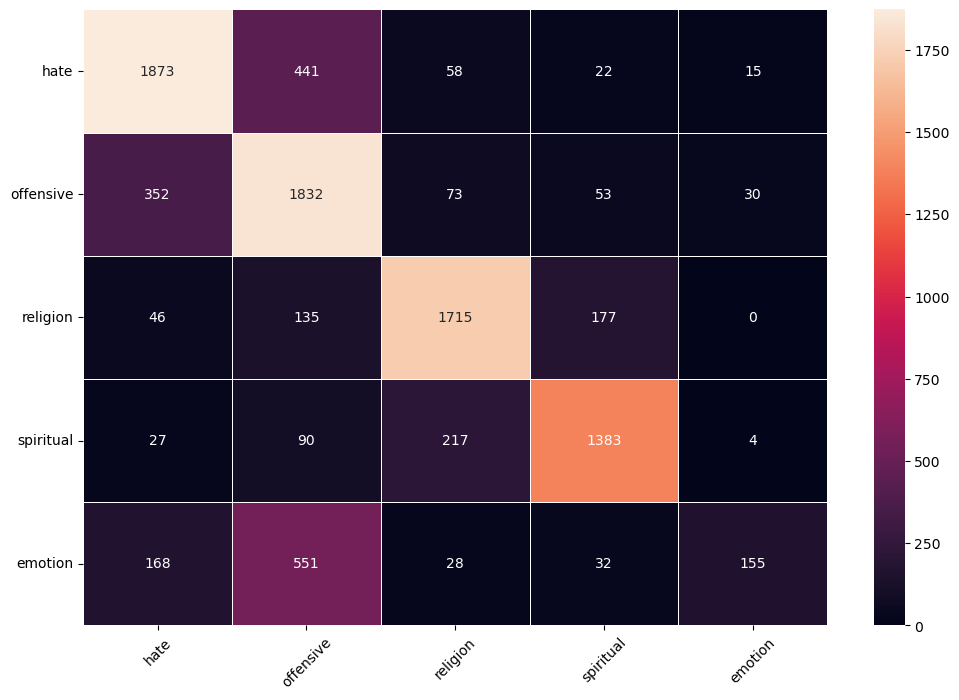

In [50]:
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_df, annot=True, fmt='d', linewidths=0.5) 
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()

In [51]:
clf.save_weights('/content/gdrive/My Drive/Data Science/saved_model/GPT2_transfer_learning')